In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


team_size = 10
pos_size = {'QB': 1, 'WR': 2, 'RB': 2, 'TE': 1}
pd.set_option('display.max.rows', 500)
pd.set_option('display.max.columns', 25)

age_modifier = { 
    "QB": [23,27,34,38],
    "WR": [23,26,29,32],
    "RB": [23,25,27,30],
    "TE": [23,27,29,32]
}

#reads rankings from human fantasy exerts
df = pd.read_csv("Rankings2022.csv", index_col="PLAYER NAME", usecols= ["RK","PLAYER NAME", "TEAM", "POS"])

#reads fantasy per game stats from selected years stores them in a dictionary
years = range(2018,2023)
stats = {year: pd.read_csv("Stats" + str(year) + ".csv", index_col="PLAYER NAME").fillna(0) for year in years}

#categories of data contained in csv
categories = ["GS","PassYds","PassTD","Int","RushAtt","RushYds","Y/A","RushTD","Tgt","Rec","RecYds","RecTD","FL","TD","PPR"]

#function to return fantasy scoring data of specified years. Use pos to specific position group, logic to determine if
#player has to have played in all years specifiedk, and weight create a weighted scoring average emphasizing the most recent years
#decay discounts stats from past years, it helps account for past stars that haven't played recently due to injury/suspension
def get_stat(start, end=None, pos="", logic='outer', weight=1, decay=1):
    total = None
    #checks proper year ranges are inserted
    if start in years and end in years and start < end:
        #merges first two years of data
        total = stats[start].merge(stats[start+1], on="PLAYER NAME", how=logic, suffixes= ("_first", "_second")).fillna(0)
        while True:
            #operations to combine per game data of the two year
            for info in ["TEAM", "POS", "Age"]:
                total[info] = np.where(total[info + "_second"]!=0, total[info + "_second"], total[info + "_first"])

            total["G"] = total['G_first'] + total['G_second']

            for category in categories:
                total[category] = (total['G_first'] * total[category + "_first"] * decay * weight + total['G_second'] * total[category + "_second"]) / (total['G_first'] * weight + total['G_second'])

            total.drop(total.filter(regex="(_first|_second)$"), axis=1, inplace = True)
            start += 1
            #checks if more years of data should be combined
            if start < end: 
                total = total.merge(stats[start+1],on="PLAYER NAME", how=logic, suffixes= ("_first", "_second")).fillna(0)
            else:
                break
    elif start in years and not end:
        total = stats[start]
    
    if isinstance(total, pd.DataFrame):
        if pos and pos.upper() in ["RB", "WR", "QB", "TE"]:
            filter = total["POS"].str.contains(pos.upper()).fillna(False)
            total = total.loc[filter]
    
    return total.sort_values(by="PPR", ascending=False)


#function to plot data of specified player over a 5 year span, VOR = Value over Replacement, which graphs the performance of 
#a typical backup
def plot_player(names, stat, VOR=False):


    fig, ax = plt.subplots()
    #plots data for each player named 
    pos_list = []
    for name in names:
        x = []
        y = []
        pos = None
        #gathers stats for each year player has played
        for year in stats.items():
            try:
                if VOR and pos == None:
                    pos = year[1].loc[name]["POS"]
                    if pos not in pos_list:
                        pos_list.append(pos)
                y.append(year[1].loc[name][stat])
                x.append(year[0])
            except KeyError:
                pass
        
        #convert data gathered to data frame
        player_data = pd.DataFrame(y, index = x)

        #compute exponential moving average of data 
        ema = player_data.ewm(com= 0.6).mean()
        
                


        #plots data points and exponential moving average
        p = ax.plot(player_data, label = name)
        ax.plot(ema, color= p[-1].get_color(), ls = ":", lw =1)

    for pos in pos_list:
        VORx = []
        VORy = []
        #compute VOR 
        for year, df in stats.items():
            VORx.append(year)
            VORy.append(get_VOR(year, pos, stat))

        VOR_data = pd.DataFrame(VORy, index=VORx)

        ax.plot(VOR_data, label = pos + " replacement")
    #sets x axis to be increments of one year
    loc = plt.MultipleLocator(base=1.0) 
    ax.xaxis.set_major_locator(loc)
    ax.set_ylim(bottom=0)
    
    #labels graphs
    plt.xlabel("Year")
    plt.ylabel(stat)
    title = " vs. ".join(names)
    plt.title(title)
    plt.legend()

    plt.show()


#function to get production of typical backup player based on team size, positional requirements,and year
def get_VOR(year, pos, stat):
    df = stats[year]
    filter = df["POS"].str.contains(pos).fillna(False)
    df = df.loc[filter]
    replacement_index = team_size * pos_size[pos]

    #adjust replacement to account for flex player 
    if pos != 'QB':
        replacement_index += int(team_size / 2)
    df = df.sort_values(by=stat, ascending=False).iloc[replacement_index: replacement_index + team_size]
    return round((df[stat].sum()/team_size),2)
            

#function to generate ranking based on weighted average of past performance, age, VOR, and expert consensus. 
def generate_ranking(pos="ALL"):
    rankings = {}

    VOR_list = {}

    for p in ["QB", "RB", "WR", "TE"]:
        VOR_list[p] = get_VOR(2022, p, "PPR")
       
    
    if pos == "ALL":
        base_stat = get_stat(2019,2022, weight= 0.49, decay=0.95)
    else:
        base_stat = get_stat(2019,2022, pos=pos, weight=0.49, decay= 0.95)

    

    for _, player in base_stat.iterrows():
        if player["POS"] in VOR_list.keys():
            ppr = player["PPR"]

            #adjust ppr based on age 
            pos_age = age_modifier[player["POS"]]
            for i, age in enumerate(pos_age):
                player_age = player["Age"]
                if player_age < age:
                    if i <= 2:
                        ppr *= 1.03
                else:
                    if i >= 3:
                        ppr *= 0.96

            #adjust ppr based on games played last year to account for injury or flukey data
            try:
                games = stats[2022].loc[player.name]["G"]
            except KeyError:
                games = 0
            if games <= 10:
                ppr *= 0.95

            delta = ppr - VOR_list[player["POS"]]
            rankings[player.name] = delta

    i = 1
    for item in sorted(rankings.items(), key= lambda item:item[1], reverse=True):
        if i < 250:
            print(f"{i}: {item}")
        i+=1
#sample usage of get_stat


display(generate_ranking())
#display(get_stat(2018, 2022, decay= 1).sort_values(by="PPR", ascending=False).head(24))
#display(get_stat(2018, pos="RB").head(12))

#display(get_stat(2019, 2022, logic='inner').head(12))



1: ('Christian McCaffrey', 11.293484616777329)
2: ('Austin Ekeler', 9.095563486186448)
3: ('Travis Kelce', 8.828016470923922)
4: ('Derrick Henry', 8.57153593440839)
5: ('Justin Jefferson', 8.281116960325738)
6: ("Ja'Marr Chase", 8.082577833229218)
7: ('Davante Adams', 7.618104466041659)
8: ('Josh Allen', 7.4444440223462465)
9: ('Jonathan Taylor', 6.914282551553585)
10: ('Tyreek Hill', 6.591109786723559)
11: ('Cooper Kupp', 6.541233439280466)
12: ('Josh Jacobs', 6.50247047911021)
13: ('Patrick Mahomes', 6.348959450326724)
14: ('Mark Andrews', 6.311074178536806)
15: ('Breece Hall', 6.19468666)
16: ('Alvin Kamara', 6.026848639536512)
17: ('Joe Mixon', 5.8938272324166)
18: ('George Kittle', 5.749624294972374)
19: ('Dalvin Cook', 5.266333345369519)
20: ('Stefon Diggs', 5.101486574804204)
21: ('Jalen Hurts', 4.968990555796726)
22: ('Nick Chubb', 4.745494898896368)
23: ('Joe Burrow', 4.739624368953628)
24: ('Saquon Barkley', 4.7218063672209425)
25: ('Lamar Jackson', 4.633293572193004)
26: ('N

None

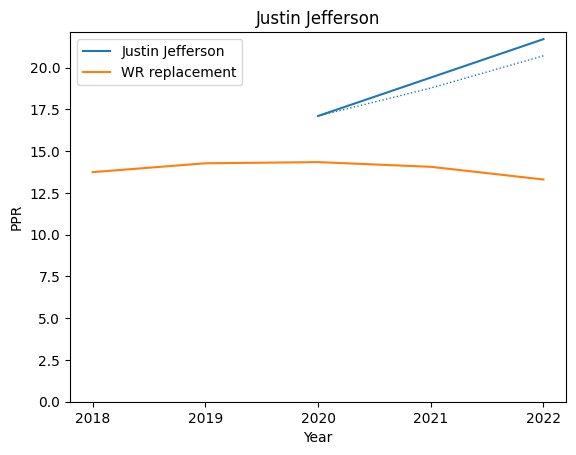

In [70]:
#sample usage of plot_player for research/comparision

plot_player(['Justin Jefferson'], 'PPR', VOR=True)
#plot_player(["Nick Chubb", "Derrick Henry"], "RushYds", VOR=True)
#plot_player(["Stefon Diggs", "Tyreek Hill"], "PPR")
#plot_player(["Patrick Mahomes", "Josh Allen", "Lamar Jackson"], "PPR", VOR=True)